In [1]:
pip install refl1d

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [5]:
#importing packages needed to generate data

import sys
import os
import math
import json
import numpy as np

import refl1d
from refl1d.names import *

#import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

In [1]:
#This block is the class that is used to generate the SLD and NR curves

from scipy.interpolate import CubicSpline
import random
def calculate_reflectivity(q, model_description, q_resolution=0.0294855):
    """
        Reflectivity calculation using refl1d
    """
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(zeros, zeros))

    layers = model_description['layers']
    sample = Slab(material=SLD(name=layers[0]['name'],
                               rho=layers[0]['sld']), interface=layers[0]['roughness'])
    # Add each layer
    for l in layers[1:]:
        sample = sample | Slab(material=SLD(name=l['name'],
                               rho=l['sld'], irho=l['isld']),
                               thickness=l['thickness'], interface=l['roughness'])

    probe.background = Parameter(value=model_description['background'], name='background')
    expt = Experiment(probe=probe, sample=sample)

    q, r = expt.reflectivity()
    z, sld, _ = expt.smooth_profile()
    #this makes all SLD curves have 900 datapoints per curve
    zNew = np.linspace(z[0], z[-1], num=900)
    newCurve = CubicSpline(z, sld)
    sldNew = []
    for i in range(zNew.shape[0]):
      sldNew.append(newCurve(zNew[i]))
    return model_description['scale'] * r, zNew, sldNew
class ReflectivityModels(object):
        # Neutrons come in from the last item in the list

    def __init__(self,first, second, q=None, name='polymer'):
                #the roughness and thickness are varied using first and second variables input into the initialization function.

        self.parameters = [
                  dict(i=0, par='roughness', bounds=[0, 5]),
                  # The following is the Si oxide layer
                  dict(i=1, par='sld', bounds=[3.0, 3.9]),
                  dict(i=1, par='thickness', bounds=[10, 25]),
                  dict(i=1, par='roughness', bounds=[1, 10]),

                  # The next two layers are the polymer
                  dict(i=2, par='sld', bounds=[0, 6.4]),
                  dict(i=2, par='thickness', bounds=[first*10, 300]),
                  dict(i=2, par='roughness', bounds=[(first-1)*10, first*10]),
                  dict(i=3, par='sld', bounds=[0, 6.4]),
                  dict(i=3, par='thickness', bounds=[10*second, 300]),
                  dict(i=3, par='roughness', bounds=[10*(second-1), 10*second]),
                 ]
        self.model_description = dict(layers=[
                                dict(sld=2.07, isld=0, thickness=0, roughness=3, name='substrate'),
                                dict(sld=3.3, isld=0, thickness=16.2139, roughness=7, name='siox'),
                                dict(sld=1.82, isld=0, thickness=random.randint(first*10, 300), roughness=random.randint((first-1)*10, first*10), name='bottom'),
                                dict(sld=3.83, isld=0, thickness=random.randint(second*10, 300), roughness=random.randint((second-1)*10, second*10), name='bulk'),
                                # dict(sld=0.0, isld=0, thickness=1000, roughness=0, name='top_layer'),
                                dict(sld=0.0, isld=0, thickness=0, roughness=0, name='air')
                         ],
                         scale=1,
                         background=0,
                        )
        # The following are unmodified physical parameters and corresponding reflectivity data
        self._pars_array = []
        self._refl_array = []
        # This creates the SLD curve list
        self._smooth_array = []
        # The following are the parameters, mapped between -1 and 1.
        self._train_pars = []
        self._train_data = None
        self._config_name = name

        if q is None:
            self.q = np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308)
        else:
            self.q = q

    @classmethod
    def from_dict(cls, pars, q_array=None):
        """
            Create ReflectivityModels object from a dict that
            defines the reflectivity model parameters and how
            the training set should be generated.
        """
        m = cls(q_array, name=pars['name'])
        m.model_description =  pars['model']
        m.parameters = pars['parameters']
        return m

    def generate(self, n=100):
        """
            Generate a random sample of models
        """
        npars = len(self.parameters)
        self._train_pars = np.random.uniform(low=-1, high=1, size=[n, npars])
        # Compute model parameters and reflectivity using these values
        self.compute_reflectivity()

    def to_model_parameters(self, pars):
        """
            Transform an array of parameters to a list of calculable models
        """
        pars_array = np.zeros(pars.shape)

        for i, par in enumerate(self.parameters):
            a = (par['bounds'][1]-par['bounds'][0])/2.
            b = (par['bounds'][1]+par['bounds'][0])/2.
            pars_array.T[i] = pars.T[i] * a + b

        return pars_array

    def compute_reflectivity(self):
        """
            Transform an array of parameters to a list of calculable models
            and compute reflectivity
        """
        print("Computing reflectivity")
        self._pars_array = self.to_model_parameters(self._train_pars)
        # Compute reflectivity
        for p in self._pars_array:
            _desc = self.get_model_description(p)
            self._refl_array.append(r)
            self._smooth_array.append([z,sld])
    def get_model_description(self, pars):
        """
            Convert the parameter list to a model description that we can use
            to compute R(q).
        """
        for i, par in enumerate(self.parameters):
            self.model_description['layers'][par['i']][par['par']] = pars[i]
        return self.model_description

    def get_preprocessed_data(self, errors=None):
        """
            Pre-process data
            If errors is provided, a random error will be added, taking the errors array
            as a relative uncertainty.
        """
        if errors is None:

            self._train_data = np.log10(self._refl_array*self.q**2/self.q[0]**2)
        else:
            _data = self._refl_array * (1.0 + np.random.normal(size=len(errors)) * errors)
            # Catch the few cases where we generated a negative intensity and take
            # the absolute value
            _data[_data<0] = np.fabs(_data[_data<0])
            self._train_data = np.log10(_data*self.q**2/self.q[0]**2)

        return self._train_pars, self._train_data

    def save(self, output_dir=''):
        """
            Save all data relevant to a training set
            @param output_dir: directory used to store training sets
        """
        # Save q values
        np.save(os.path.join(output_dir, "%s_q_values" % self._config_name), self.q)

        # Save training set
        if self._train_data is not None:
            np.save(os.path.join(output_dir, "%s_data" % self._config_name), self._train_data)
            np.save(os.path.join(output_dir, "%s_pars" % self._config_name), self._train_pars)

    def load(self, data_dir=''):
        self.q = np.load(os.path.join(data_dir, "%s_q_values.npy" % self._config_name))
        self._train_data = np.load(os.path.join(data_dir, "%s_data.npy" % self._config_name))
        self._train_pars = np.load(os.path.join(data_dir, "%s_pars.npy" % self._config_name))
        return self.q, self._train_data, self._train_pars


5 4
Computing reflectivity


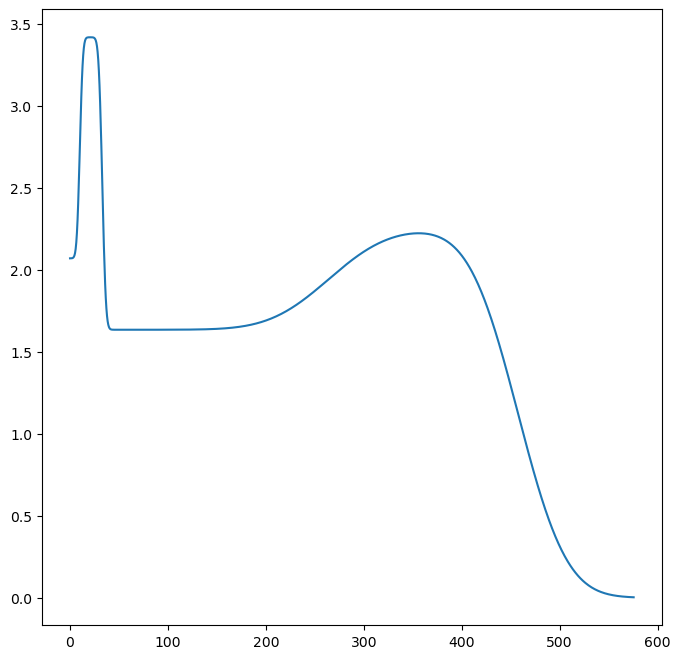

(100000, 2, 308) (100000, 2, 900)
5 5
Computing reflectivity


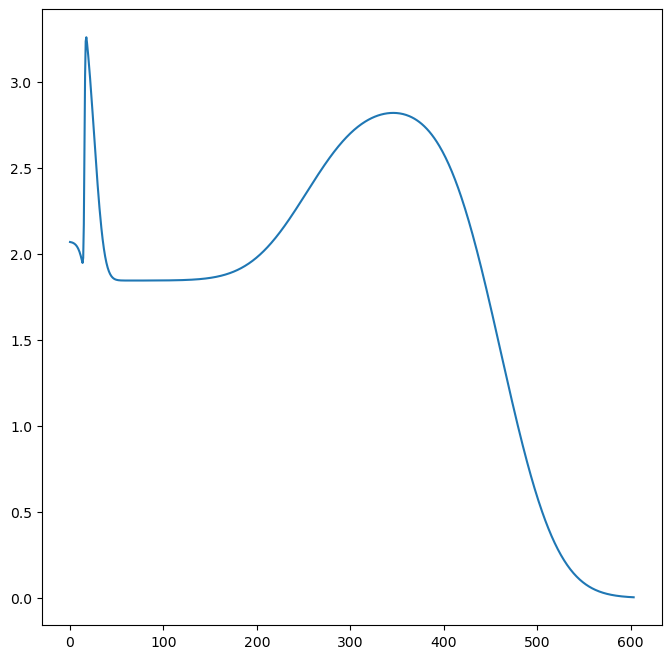

(100000, 2, 308) (100000, 2, 900)


In [7]:
# NOTE: Here I would pass the q-array of the time-resolved data when instantiating this object.

count = 0
# Generate 100 curves
for first in range(1,6):
    for second in range(1,6):
        print(first, second)
        m = ReflectivityModels(first, second)
        #number of curves being generated
        m.generate(10000000)
        pars, train_data = m.get_preprocessed_data()
        min_x = float('inf')
        max_x = -float('inf')
        #moving all SLD curves along the x axis such that they all start at x=0
        for index in range(len(m._smooth_array)):
          min_x = min(m._smooth_array[index][0])
          for i in range(len(m._smooth_array[index][0])):
            m._smooth_array[index][0][i] -= min_x
        #saving as npy files
        settingUp = []
        SLDSet = []
        for i in range(len(m._smooth_array)):
          settingUp.append(np.array([m.q,m._refl_array[i]]))
          SLDSet.append(np.array(m._smooth_array[i]))
        totalStack = np.stack(settingUp)
        totalParams = np.stack(SLDSet)
        print(totalStack.shape, totalParams.shape)
        np.save("SLD_CurvesPoly" + str(first) + str(second) + ".npy", totalParams)
        np.save("NR-SLD_CurvesPoly" + str(first) + str(second) + ".npy", totalStack)

